In [1]:
import pandas as pd
import numpy as np
import folium

from gnact import utils, clust, network
import db_config

from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')

# create the engine to the database
engine = utils.connect_engine(db_config.colone_cargo_params, print_verbose=True)

Creating Engine...
Engine created for ais_cargo
PostgreSQL 12.3 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-39), 64-bit


## Demonstration of Plotting and Density Based Clustering Methods

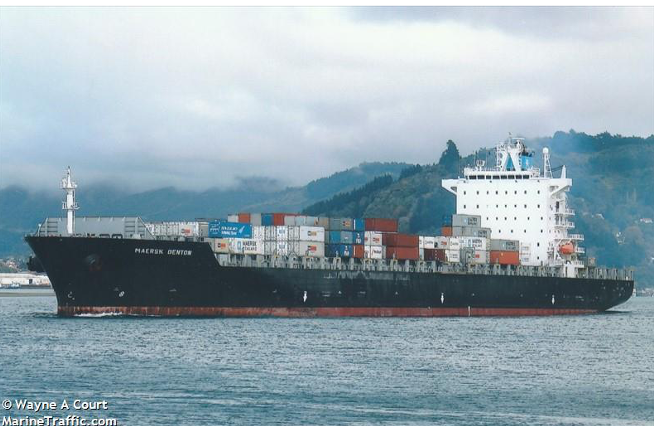

Reducing dense, geospatial datasets to starts and stops of indvidual selectors challenges conventional GIS techniques.  In the following examples, we will use ship position data from AIS to track the MSC ARUSHI (MMSI:636016432) during its voyages in 2017.  We'll look over several different density based clustering methods, static trip segmentation based on known sites, and an implementation of dynamic trip segmentation from Scikit-Mobility.

### Plot of Raw Data

In [2]:
# make the df from the data in the database for MSC Ashrui
df_posits = clust.get_uid_posits(('636016432',), engine, end_time='2018-01-01')
df_posits.head()

id       lat       lon                time
0  15867231  42.28535 -69.12919 2017-01-06 07:04:31
1  15867232  42.28576 -69.14447 2017-01-06 07:06:31
2  15867550  42.28601 -69.15519 2017-01-06 07:07:55
3  15867549  42.28627 -69.16453 2017-01-06 07:09:08
4  15867237  42.28669 -69.17284 2017-01-06 07:10:13

In [3]:
# plot with Folium
m = folium.Map(location=[df_posits.lat.median(), df_posits.lon.median()],
               zoom_start=4, tiles='OpenStreetMap')
points = list(zip(df_posits.lat, df_posits.lon))
folium.PolyLine(points).add_to(m)
m

In [4]:
df_sites = clust.get_sites_wpi(engine)
df_sites.head()

site_id    site_name        lat         lon region
0    61090     SHAKOTAN  43.866667  146.833333   None
1    61110  MOMBETSU KO  44.350000  143.350000   None
2    61120  ABASHIRI KO  44.016667  144.283333   None
3    61130    NEMURO KO  43.333333  145.583333   None
4    61140  HANASAKI KO  43.283333  145.583333   None

In [ ]:
df_sites_ports = pd.read_csv('Port_Facilities.csv')
df_sites_ports = df_sites_ports[df_sites_ports['facility_t'].isin(['Dock', 'Marinia'])]
df_sites = df_sites_ports[['id', 'nav_unit_n', 'latitude11', 'longitude1', 'facility_t']]
df_sites.columns = ['site_id', 'site_name', 'lat', 'lon', 'facility_type']
print(len(df_sites))
print(len(df_sites.drop_duplicates(['lat','lon'], keep='first')))

df_sites = df_sites.drop_duplicates(['lat','lon'], keep='first')
df_sites['region'] = 'us_ports'

In [ ]:
df_sites_ports['facility_t'].unique()

In [ ]:
east_coast = df_sites[(df_sites.region=='East_Coast')| (df_sites.region=='Gulf_Carrib')]
clust.plot_sites(east_coast)

### Identification and addition of ports not included in the original dataset
Our dataset is not perfect and the ship frequently goes to ports near Boston, Newark, and Savannah not in the dataset.  Therefore, we will add them here.

In [ ]:
clust.plot_sites(east_coast.iloc[-3:])

### Calculate Nearest Site for Each Position
This will be used to evaluate the accuracy of each clustering method/hyperparameter set.  The rationale is that if there are a certain number of minimum points from the original data within a certain distance threshold from a known site, there should be a cluster identified within that same certain distance at that site.

We will calculate precision, recall, and the F1 Measure.  The precision will be the number of true positives (total number of sites where clusters ar found) divided by total number of clusters found by this method.  Recall will be the number of true positives found by the method divided by the number of sites where the original data was close by.

In [5]:
df_nn = clust.calc_nn(df_posits, df_sites)
df_nn.head()

id  nearest_site_id  dist_km
0  15867231             7290   120.10
1  15867232             7290   118.45
2  15867550             7290   117.30
3  15867549             7290   116.29
4  15867237             7290   115.40

## Static Trip Segmentation: Ground Truth Based Activity
We will generate clusters for all positions that spend a minimum amount of time with a certain distance of any site.  This is startic trip segmentation, and will have the lowest false positive rate of any method group because all positions clustered must be within a certain distance of a known port.

This method will work great for finding ports we know, but cannot find ports beyond the distance threshold of known ports.  Despite this limitation, it is an excellent resource for evaluating precision and recall.  We can determine how many ports were found with this method, and then compute precision, recall, and F1 score for other methods.

In [23]:
df_edgelist = network.calc_edgelist(df_posits, df_nn, dist_km=3, loiter_time_mins=420)
df_edgelist

node  destination        arrival_time         depart_time  \
0       0       7830.0 2017-01-06 07:04:31 2017-01-08 10:16:16   
4    7810       7850.0 2017-01-08 11:23:07 2017-01-09 07:05:57   
10      0       8030.0 2017-01-09 08:21:57 2017-01-09 22:58:52   
21   8120          0.0 2017-01-10 01:39:17 2017-01-10 15:13:27   
32      0       9985.0 2017-01-10 18:15:36 2017-01-13 03:17:56   
33   9985          0.0 2017-01-13 10:06:34 2017-01-14 21:35:27   
34      0       7830.0 2017-01-14 21:51:17 2017-02-23 03:23:25   
38   7810       7850.0 2017-02-23 04:47:15 2017-02-23 23:58:58   
44      0       8030.0 2017-02-24 01:04:50 2017-02-24 17:00:23   
55   8120          0.0 2017-02-24 19:53:58 2017-02-25 09:50:48   
66      0       8530.0 2017-02-25 12:38:47 2017-02-27 21:15:18   
68      0       8530.0 2017-02-27 21:51:58 2017-02-28 05:50:46   
70      0       7830.0 2017-02-28 06:17:17 2017-04-14 08:21:42   
74   7810       7850.0 2017-04-14 09:52:13 2017-04-15 00:32:49   
80      0       8030.0 2017-04-15 01:47:45 2017-04-15 16:26:48   
91   8120          0.0 2017-04-15 19:08:47 2017-04-16 07:44:28   
102     0       8530.0 2017-04-16 10:23:41 2017-04-18 07:54:12   
104     0       8530.0 2017-04-18 08:26:12 2017-04-18 16:19:40   
106     0       7830.0 2017-04-18 16:49:50 2017-06-02 23:20:45   
110  7810       7850.0 2017-06-03 00:52:56 2017-06-04 10:19:55   
114     0       8030.0 2017-06-04 11:22:58 2017-06-07 00:09:34   
125  8120          0.0 2017-06-07 03:05:20 2017-06-08 02:20:20   
136     0       7830.0 2017-06-08 05:08:55 2017-06-30 06:21:37   
140  7810       7850.0 2017-06-30 07:43:09 2017-07-01 05:26:46   
144     0       8030.0 2017-07-01 06:52:26 2017-07-01 22:01:17   
155  8120          0.0 2017-07-02 00:29:41 2017-07-02 13:59:43   
166     0       9985.0 2017-07-02 16:10:58 2017-07-05 12:55:54   
167  9985          0.0 2017-07-05 14:57:14 2017-07-06 06:42:47   
168     0       8030.0 2017-07-06 06:53:46 2017-07-15 15:52:00   
179  8120          0.0 2017-07-15 18:33:38 2017-07-16 09:55:14   
190     0       7830.0 2017-07-16 12:35:10 2017-08-10 08:12:02   
194  7810       7850.0 2017-08-10 10:18:33 2017-08-11 04:03:55   
200     0       8030.0 2017-08-11 05:19:10 2017-08-12 06:06:13   
211  8120          0.0 2017-08-12 08:39:29 2017-08-13 06:10:04   
222     0       8030.0 2017-08-13 09:03:08 2017-08-25 12:55:19   
233  8120          0.0 2017-08-25 15:43:00 2017-08-26 10:41:06   
244     0       7830.0 2017-08-26 12:56:13 2017-09-15 05:21:10   
248  7810       7850.0 2017-09-15 06:48:31 2017-09-16 07:23:45   
254     0       8030.0 2017-09-16 08:41:43 2017-09-16 21:56:02   
265  8120          0.0 2017-09-17 00:30:19 2017-09-17 12:11:21   
276     0       8030.0 2017-09-17 14:35:44 2017-09-27 19:06:34   
287  8120          0.0 2017-09-27 22:07:33 2017-09-28 12:40:09   
298     0       8030.0 2017-09-28 15:10:41 2017-12-29 13:11:45   
309  8120          0.0 2017-12-29 16:15:02 2017-12-30 05:12:04   
320     0       7830.0 2017-12-30 07:56:41 2017-12-31 00:21:40   
324  7810       7850.0 2017-12-31 01:44:40 2017-12-31 17:33:28   

           time_diff  position_count  
0    2 days 03:11:45          1981.0  
4    0 days 19:42:50           405.0  
10   0 days 14:36:55           789.0  
21   0 days 13:34:10           358.0  
32   2 days 09:02:20          1264.0  
33   1 days 11:28:53             2.0  
34  39 days 05:32:08          3009.0  
38   0 days 19:11:43           407.0  
44   0 days 15:55:33           857.0  
55   0 days 13:56:50           298.0  
66   2 days 08:36:31          2121.0  
68   0 days 07:58:48           211.0  
70  45 days 02:04:25          4018.0  
74   0 days 14:40:36           321.0  
80   0 days 14:39:03           789.0  
91   0 days 12:35:41           281.0  
102  1 days 21:30:31          2319.0  
104  0 days 07:53:28           204.0  
106 45 days 06:30:55          3981.0  
110  1 days 09:26:59           686.0  
114  2 days 12:46:36          1829.0  
125  0 days 23:15:00           506.0  
136 2

In [24]:
df_nearby_activity = network.calc_nearby_activity(df_edgelist, df_sites)
df_nearby_activity

site_id         site_name        lat        lon       region
2955     7810            NEWARK  40.700000 -74.150000   East_Coast
2957     7830      STAPLETON SI  40.633333 -74.066667   East_Coast
2958     7850  PORT RICHMOND SI  40.650000 -74.133333   East_Coast
2974     8030        NEW CASTLE  39.650000 -75.566667   East_Coast
2980     8120        GLOUCESTER  39.900000 -75.133333   East_Coast
3022     8530          SAVANNAH  32.083333 -81.083333   East_Coast
3130     9985          FREEPORT  26.516667 -78.783333  Gulf_Carrib

In [30]:
df_edgelist = network.calc_edgelist(df_posits, df_nn, dist_km=3, loiter_time_mins=420)
df_nearby_activity = network.calc_nearby_activity(df_edgelist, df_sites)

m = clust.plot_sites(df_nearby_activity)
points = list(zip(df_posits.lat, df_posits.lon))
folium.PolyLine(points).add_to(m)
m

Plotted 7 total sites.


In [33]:
df_edgelist.groupby(['node','destination']).agg('count')

arrival_time  depart_time  time_diff  position_count
node destination                                                      
0    7830.0                  8            8          8               8
     8030.0                 11           11         11              11
     8530.0                  4            4          4               4
     9985.0                  2            2          2               2
7810 7850.0                  8            8          8               8
8120 0.0                    11           11         11              11
9985 0.0                     2            2          2               2

In [14]:
df_nearby_activity

site_id         site_name        lat        lon       region
2955     7810            NEWARK  40.700000 -74.150000   East_Coast
2957     7830      STAPLETON SI  40.633333 -74.066667   East_Coast
2958     7850  PORT RICHMOND SI  40.650000 -74.133333   East_Coast
2974     8030        NEW CASTLE  39.650000 -75.566667   East_Coast
2980     8120        GLOUCESTER  39.900000 -75.133333   East_Coast
3022     8530          SAVANNAH  32.083333 -81.083333   East_Coast
3130     9985          FREEPORT  26.516667 -78.783333  Gulf_Carrib

In [34]:
df_nearby_activity_cleaned = df_nearby_activity[df_nearby_activity.site_name
                                                .isin(['GLOUCESTER','FREEPORT'])]

boston_site = {'site_id':1, 'site_name': 'BOSTON_MANUAL_1', 'lat': 42.342124, 'lon':-71.018312, 
               'region':'East_Coast'}
newark_site = {'site_id':2, 'site_name': 'NEWARK_MANUAL_1', 'lat': 40.682164, 'lon':-74.148607, 
               'region':'East_Coast'}
savannah_site = {'site_id':3, 'site_name': 'SAVANNAH_MANUAL_1', 'lat': 32.121167, 'lon':-81.130085, 
               'region':'East_Coast'}


df_nearby_activity_cleaned = (df_nearby_activity_cleaned
.append(newark_site, ignore_index=True) # add Newark
.append(boston_site, ignore_index=True) # add Boston
.append(savannah_site, ignore_index=True)) # add savannah

m = clust.plot_sites(df_nearby_activity_cleaned)
points = list(zip(df_posits.lat, df_posits.lon))
folium.PolyLine(points).add_to(m)
m

Plotted 5 total sites.


In [ ]:
m = clust.plot_sites(df_nearby_activity_cleaned)
points = list(zip(df_posits.lat, df_posits.lon))
folium.PolyLine(points).add_to(m)
m

In [35]:
df_centers = calc_centers(df_clusts)
df_nearest_sites = calc_nn(df_centers, df_sites, lat='average_lat', lon='average_lon', id='clust_id')
df_clust_rollup = pd.merge(df_centers, df_nearest_sites, how='inner', left_on='clust_id', right_on='id')
df_clust_rollup = df_clust_rollup[['clust_id', 'nearest_site_id', 'dist_km', 'total_clust_count',
                                   'average_lat', 'average_lon']]

df_stats = pd.merge(df_clust_rollup, df_nearby_activity,
                    how='outer', left_on='nearest_site_id', right_on='site_id', indicator=True)

NameError: name 'calc_centers' is not defined